# fastLink

This notebook tests fastLink on small examples based on paper for record linkage:
[Using a Probabilistic Model to Assist Merging of Large-Scale
Administrative Records](https://imai.fas.harvard.edu/research/files/linkage.pdf).

## EM Algorithm

### Mixture of Gaussians

Set up:

* Given a training set: {$x^{(1)}$, $x^{(2)}$, $x^{(3)}$, ..., $x^{(m)}$}
* We want to model the data by specifying a joint distribution $p({x^{(i)}}, {z^{(i)}}) = p({x^{(i)}}|{z^{(i)}})p({z^{(i)}})$
* Let $k$ denote the number of values that ${z^{(i)}}$'s can take
* ${z^{(i)}}$ ~ Multinomial($\phi$), where $\phi_{j}$ >= 0, and the $\sum \limits _{j=1} ^{k} \phi_{j}$= 1. The parameter $\mu_{j}$ gives $p({z^{(i)}} = j)$, $x^{i}|z^{i}$ given by $N({\mu_{j}}, \sum _{j})$
* Note that the $z_{(i)}$'s are latent random variables, meaning that they are hidden/unobserved

### EM explained

Think of this scenario as: we have a set of X's coming from two (can be more) Gaussian distributions N1 and N2, parameterized by $({\mu_{1}}, {\sigma_{1}^{2}})$, and $({\mu_{2}}, {\sigma_{2}^{2}})$, respectively. Their labels (given by z) have been removed, so we don't know which Gaussian distribution they originally come from. The task is trying to find their labels.

We start from some initial guesses of $\mu$'s and $\sigma$'s. The EM algorithm is an iterative algorithm that has two main steps: 
* E-step: Using the guesses of model parameters, for each point, calculate the probability that $z^{(i)}$ takes each value from 1 to k.
* M-step: Using the probability given by the above E-step, re-calculate the model parameters by maximizing the likelihood of the joint distribution $p({x^{(i)}}, {z^{(i)}})$
* Repeat the above two steps until convergence

This can be formally written as below:

1. **Goal**: to maximize the joint distribution $p({x^{(i)}}, {z^{(i)}})$:

$$
l(\phi, \mu, \Sigma) = \sum \limits _{i = 1} ^{m} log(p(x^{(i)};\phi, \mu, \Sigma)) = \sum \limits _{i = 1} ^{m} log \sum \limits _{z^{(i)} = 1} ^{k} (p(x^{(i)}|z^{(i)};\mu, \Sigma)p(z^{(i)};\phi))
$$

2. Repeat until convergence:{

     (E-step) For each $i$, $j$, set
        
      $$
      w_{j} := p(z^{(i)} = j|x^{(i)};\phi, \mu, \Sigma)
      $$

     (M-step) update the parameters using:
     
      $$
      \phi_{j} := \frac{1}{m} \sum \limits _{i} ^{m} w_{j}^{(i)}
      $$
      $$
      \mu_{j} := \frac {\sum \limits _{i = 1} ^{m} w_{j}^{(i)}x^{(i)}}{\sum \limits _{i = 1} ^{m} w_{j}^{(i)}}
      $$
      $$
      \Sigma_{j} := \frac {\sum \limits _{i = 1} ^{m} w_{j}^{(i)}(x^{(i)} - \mu_{j})(x^{(i)} - \mu_{j})^{T}}{\sum \limits _{i = 1} ^{m} w_{j}^{(i)}}
      $$
      
      
}



## A toy example

Assume that there are two Gaussian distributions with true parameters: $(10, 5^{2})$, $(20, 4^{2})$

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns; sns.set()

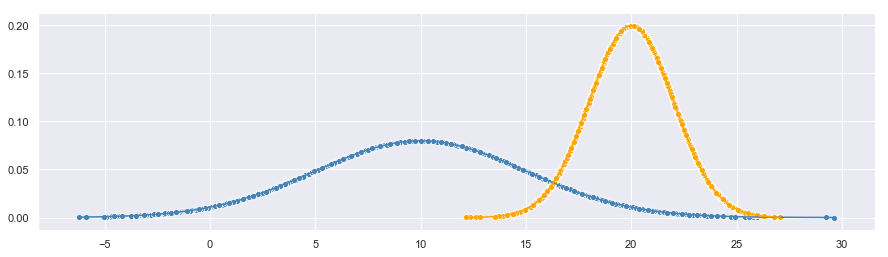

In [351]:
# generate the points:
rng = np.random.RandomState(42)

x1 = rng.normal(10, 5, 5000)
x2 = rng.normal(20, 2, 5000)
y1 = ss.norm.pdf(x1, 10, 5)
y2 = ss.norm.pdf(x2, 20, 2)

# plot the distributions
fig, ax = plt.subplots(figsize= (15, 4))
sns.lineplot(x1, y1, ax = ax, color = 'steelblue')
sns.lineplot(x2, y2, ax = ax, color = 'orange')
sns.scatterplot(x1, y1, ax = ax, color = 'steelblue')
sns.scatterplot(x2, y2, ax = ax, color = 'orange')

X_all = np.hstack((x1, x2))

Now we remove the labels of the two X's and mix them up. Therefore the tag that x belongs to x1 or x2 becomes the hidden variable. We want to run the EM algorithm to find out which distribution the points originally come from.

In [337]:
def e_step(X, phi, mu, sigma, N, K):
    
    '''
    for each training point, each class of z:
    estimate p(zi = j|x;phi, mu, sigma)
    
    which is the probability of z being j given x parameterized by phi, mu and sigma
    
    Input: 
    X - m training examples
    phi: prior of z, K values
    mu: k values
    sigma: k * k 
    
    '''
    
    weights = np.zeros((N, K))
    products = np.zeros((N, K))
    
    for k in range(K):
        product_sum = 0
            # calculate probability density given distribution
        p = ss.norm.pdf(X, mu[k], sigma[k])
        products[:, k] = p * phi[k]
        
    weights = products / np.sum(products, axis = 1).reshape((N, 1))      
    
    return weights


def m_step(X, weights, N, K): 
    
    # update the parameters:
    phi = np.sum(weights, axis = 0) / len(weights)

    mu = np.sum(weights * X.reshape(N, 1), axis= 0) / np.sum(weights, axis = 0)
    
    sigma = np.sqrt(np.sum(weights * ((X.reshape(N, 1) - mu)**2), axis = 0) / np.sum(weights, axis = 0))
    
    
    return phi, mu, sigma

def em_func(X, phi, mu, sigma, max_iter = 1000):
    
    # number of training examples
    N = len(X)
    
    # number of Gaussians (classes)
    K = len(phi)
    
    idx = 0
        
    while idx < max_iter:
        
        weights = e_step(X, phi, mu, sigma, N, K)
        
        phi, mu, sigma = m_step(X, weights, N, K)
        
        idx += 1
        
        if idx >= 995:
            print(str(idx) + '-th iteration...')
            print(phi, mu, sigma)
            print('-------')
        
    return phi, mu, sigma

In [338]:
# test
phi = [0.5, 0.5]
mu = [6, 12]
sigma = [6, 9]

em_func(X_all, phi, mu, sigma)

995-th iteration...
[0.50360279 0.49639721] [10.0941835  19.98534996] [5.02991477 2.01441455]
-------
996-th iteration...
[0.50360279 0.49639721] [10.0941835  19.98534996] [5.02991477 2.01441455]
-------
997-th iteration...
[0.50360279 0.49639721] [10.0941835  19.98534996] [5.02991477 2.01441455]
-------
998-th iteration...
[0.50360279 0.49639721] [10.0941835  19.98534996] [5.02991477 2.01441455]
-------
999-th iteration...
[0.50360279 0.49639721] [10.0941835  19.98534996] [5.02991477 2.01441455]
-------
1000-th iteration...
[0.50360279 0.49639721] [10.0941835  19.98534996] [5.02991477 2.01441455]
-------


(array([0.50360279, 0.49639721]),
 array([10.0941835 , 19.98534996]),
 array([5.02991477, 2.01441455]))

## Data Loading